In [1]:
import seaborn as sns

In [2]:
sns.__version__

'0.11.2'

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
# import some data to play with

def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

df_iris = sklearn_to_df(datasets.load_iris())
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
mapping = dict(zip([0,1,2], datasets.load_iris()['target_names']))
df_iris['target_label'] = df_iris['target'].map(mapping)

In [5]:
setosa = df_iris[df_iris['target_label'] == 'setosa']
versicolor = df_iris[df_iris['target_label'] == 'versicolor']

In [6]:
setosa_sl = setosa['sepal length (cm)']
versicolor_sl = versicolor['sepal length (cm)']

In [7]:
def full_permutation_test(control, variant, nreps, tail, viz = False, seed = 42):
    
    if tail not in ['left', 'right', 'two']:
        raise ValueError("results: status must be one in ['left', 'right'].")
    if tail == 'left':
        condition = 'lower'
    elif tail == 'right':
        condition = 'higher'
    else:
        condition = ''
    
    np.random.seed(seed)
    #difference of means: H0 is that belonging to the variant group does not improve the chosen metric
    test_stat = np.mean(variant) - np.mean(control)
    permuted_means = []
    p_more_extreme_values = 0
    
    #len indexes
    idx_c = len(control)
    idx_v = len(variant)
    
    #prepare permutations
    for i in range(nreps):
        #pull the two lists together and shuffle them
        joined = np.concatenate((control,variant), axis=0)
        shuffled = np.random.permutation(joined)
        
        #define the two groups, whose length was assessed out of loop
        sim_c = shuffled[:idx_c]
        sim_v = shuffled[idx_c:] 
       
        #calculate test statistic and append to results list
        if tail == 'two':
            sim_stat = abs(np.mean(sim_c) - np.mean(sim_v))
        else: 
            sim_stat = np.mean(sim_v) - np.mean(sim_c)
        
        permuted_means.append(sim_stat)        
        
        # Defining the probability according to the direction of the test:
        # if H0 is based on variant results not being HIGHER than control results, 
        # p_more_extreme_values increases if we observe values higher than the test stat.
        # if H0 is based on variant results not being LOWER than control results, 
        # p_more_extreme_values increases if we observe values lower than the test stat.

        if tail == 'left':
            if sim_stat <= test_stat:
                p_more_extreme_values += 1    
        elif tail in str(['two','right']):
            if sim_stat >= test_stat:
                p_more_extreme_values += 1
    
    #set up a series that contains nreps permuted mean differences
    p = p_more_extreme_values / nreps   
    output = pd.Series(permuted_means, name='permuted_mean_differences') 
    
    if viz == True:
        sns.histplot(x = 'permuted_mean_differences', kde = True, data = output.to_frame())
        plt.xlabel('permuted mean differences')
        plt.axvline(test_stat,
                    label=f'Original Mean difference = {round(test_stat,2)}', 
                    c ='red')
        plt.axvline(np.mean(output),
                    label=f'Permuted Mean difference = {round(np.mean(output),2)}', 
                    c ='blue')
        plt.legend()
    
    print(f'The probability of observing values more extreme ({condition}) than {round(test_stat,2)} is {p}')
    return output 

The probability of observing values more extreme () than 0.93 is 0.0


0      0.198
1      0.286
2      0.122
3      0.010
4      0.114
       ...  
995    0.262
996    0.274
997    0.026
998    0.134
999    0.022
Name: permuted_mean_differences, Length: 1000, dtype: float64

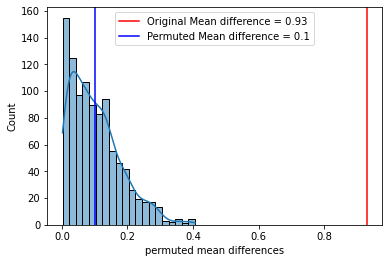

In [8]:
full_permutation_test(setosa_sl, versicolor_sl, 1000, tail='two', viz=True)

In [9]:
from statsmodels.stats.proportion import proportions_chisquare
def chisquare_with_residuals(ft):
    # reference: https://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1269&context=pare
    nrows = ft.shape[0]
    count = ft[1]
    nobs = (ft[0] + ft[1])
    chisq = proportions_chisquare(count, nobs)
    #calculating residuals: observed
    observed = chisq[2][0].T[0]
    expected = chisq[2][1].T[0]
    residuals = observed - expected
    std_res = residuals / np.sqrt(expected)

    #adjusted residuals
    row_marginals = ft[1] #nobs
    column_marginals = ft.sum()[1]
    n = ft.sum().sum()
    adj_residuals = (observed - expected) / np.sqrt(expected*(1-row_marginals/n)*(1-column_marginals/n))
    
    concat = np.concatenate([observed,expected,residuals,std_res, adj_residuals]).reshape(-1,nrows)
    output = pd.DataFrame(np.transpose(concat), index=ft.index, 
                          columns=['observed','expected','residuals','std_residual','adj_std_res']
                         )
    return output

In [10]:
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [11]:
tt = pd.pivot_table(df_titanic, index='class', columns='survived', values='alive', aggfunc='count')

In [12]:
tt

survived,0,1
class,,
First,80,136
Second,97,87
Third,372,119


In [13]:
from statsmodels.stats.proportion import proportions_chisquare

count = tt[1]
nobs = (tt[1]+tt[0])
proportions_chisquare(count, nobs)

(102.88898875696057,
 4.5492517112987287e-23,
 (array([[136,  80],
         [ 87,  97],
         [119, 372]], dtype=int64),
  array([[ 82.90909091, 133.09090909],
         [ 70.62626263, 113.37373737],
         [188.46464646, 302.53535354]])))

In [14]:
chisquare_with_residuals(tt)

,observed,expected,residuals,std_residual,adj_std_res
class,,,,,
First,136.0,82.909091,53.090909,5.830678,8.069324
Second,87.0,70.626263,16.373737,1.948340,2.612933
Third,119.0,188.464646,-69.464646,-5.059981,-6.925191


In [15]:
agadan = pd.DataFrame(index=['treat1', 'treat2', 'control'], columns=[0,1], data=[[3211, 1282],
                                                                                       [3240, 1193],
                                                                                       [1015, 320]
                                                                                      ])
agadan

,0,1
treat1,3211,1282
treat2,3240,1193
control,1015,320


In [16]:
from statsmodels.stats.proportion import proportions_chisquare

count = agadan[1]
nobs = (agadan[1]+agadan[0])
proportions_chisquare(count, nobs)

(11.234950930188084,
 0.003633803202112845,
 (array([[1282, 3211],
         [1193, 3240],
         [ 320, 1015]], dtype=int64),
  array([[1223.85098918, 3269.14901082],
         [1207.50755287, 3225.49244713],
         [ 363.64145795,  971.35854205]])))

In [17]:
chisquare_with_residuals(agadan)

,observed,expected,residuals,std_residual,adj_std_res
treat1,1282.0,1223.850989,58.149011,1.662180,2.083098
treat2,1193.0,1207.507553,-14.507553,-0.417493,-0.520642
control,320.0,363.641458,-43.641458,-2.288561,-2.725795
